In [2063]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import os, sys

import numpy as np
import pandas as pd
import shap

from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt

import talib
from pathlib import Path

from collections import defaultdict, Counter

In [2064]:
DAYS_IN_YEAR = 365
HOURS_IN_DAY = 24
MINUTES_IN_HOUR = 60

In [2065]:
root_dir = Path('/Users/chenxu/Work/Crypto/')
os.chdir(root_dir)
os.getcwd()

'/Users/chenxu/Work/Crypto'

In [2066]:
btc_dir = root_dir / 'spot/monthly/klines/BTCUSDT/1m'
eth_dir = root_dir / 'spot/monthly/klines/ETHUSDT/1m'

In [2067]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [2068]:
train_start, train_end = '2023-05', '2023-09'
valid_start, valid_end = '2023-09', '2023-10'
test_start,  test_end  = '2023-10', '2023-11'

In [2069]:
# df = pd.read_csv('data_ml.csv', index_col=['datetime'], parse_dates=['datetime'])
# len(df)

btc_train_files, btc_valid_files, btc_test_files = [], [], []
eth_train_files, eth_valid_files, eth_test_files = [], [], []

def get_raw_files(directory, train_set, valid_set, test_set):
    for f in directory.iterdir():
        name, _ = f.name.split('.')
        month = name[-7:]
        if month < train_start or month >= test_end:
            continue
        if month < train_end:
            train_set += f,
        elif month < valid_end:
            valid_set += f,
        else:
            test_set += f,

get_raw_files(btc_dir, btc_train_files, btc_valid_files, btc_test_files)
get_raw_files(eth_dir, eth_train_files, eth_valid_files, eth_test_files)

In [2070]:
headers = [
            "open_time",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_volume",
            "n_trades",
            "taker_buy_base_volume",
            "taker_buy_quote_volume",
            "ignore",
          ]

In [2071]:
def load_one_csv(filename: Path, headers: list, time_to_use: str, time_unit: int) -> pd.DataFrame:
    df = pd.read_csv(filename, header=None, names=headers)
    df.sort_values(time_to_use, inplace=True)
    df.drop_duplicates(subset=[time_to_use], keep="first", inplace=True)
    df["datetime"] = pd.to_datetime(df[time_to_use], unit=time_unit).dt.tz_localize(None)
    df.drop(labels=["open_time", "close_time", "ignore"], axis=1, inplace=True)
    df.set_index("datetime", inplace=True)
    return df.sort_index()

In [2264]:
def load_raw(files):
    res = []
    for f in files:
        df = load_one_csv(f, headers, 'open_time', 'ms')
        res += df,
    return pd.concat(res).sort_index()

df_btc_train = load_raw(btc_train_files)
df_btc_valid = load_raw(btc_valid_files)
df_btc_test  = load_raw(btc_test_files)

df_eth_train = load_raw(eth_train_files)
df_eth_valid = load_raw(eth_valid_files)
df_eth_test  = load_raw(eth_test_files)

print(f'BTC train: {len(df_btc_train)}')
print(f'BTC valid: {len(df_btc_valid)}')
print(f'BTC test:  {len(df_btc_test)}')
print(f'ETH train: {len(df_eth_train)}')
print(f'ETH valid: {len(df_eth_valid)}')
print(f'ETH test:  {len(df_eth_test)}')

BTC train: 177120
BTC valid: 43200
BTC test:  44640
ETH train: 177120
ETH valid: 43200
ETH test:  44640


In [2265]:
def gen_features(df: pd.DataFrame, train: bool = False, lookbacks: list = [10, 15, 30, 60, 60 * 2, 60 * 4, 60 * 24]):
    fields_1 = defaultdict(lambda: pd.Series)
    fields_2 = defaultdict(lambda: pd.Series)

    for lb in lookbacks:
        df_ret = np.log(df['close']).diff()
        df_ret_lb = df_ret.rolling(window=lb).sum()
        df_sd_lb  = df_ret.rolling(window=lb).std()
        df_sh_lb  = df_ret_lb.div(df_sd_lb) * np.sqrt(1. / lb)
        df_quote_vol     = df['quote_volume'].rolling(window=lb).sum()
        df_n_trades      = df['n_trades'].rolling(window=lb).sum()
        df_buy_quote_vol = df['taker_buy_quote_volume'].rolling(window=lb).sum()
        df_quote_vol_2d  = df_quote_vol.rolling(window=60*48, min_periods=60*24).median()
        df_n_trades_2d   = df_n_trades.rolling(window=60*48, min_periods=60*24).median()

        df_vol_per_trade = df_quote_vol.div(df_n_trades)
        df_vol_per_trade_2d = df_vol_per_trade.rolling(window=60*48, min_periods=60*24).median()

        df_adx = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=lb)

        df_apo = talib.APO(df['close'], fastperiod=lb, slowperiod=lb*2)
        df_apo_high = df_apo.rolling(window=60*48, min_periods=60*24).max()
        df_apo_low = df_apo.rolling(window=60*48, min_periods=60*24).min()

        df_aroonosc = talib.AROONOSC(df['high'], df['low'], timeperiod=lb)
        df_rsi = talib.RSI(df['close'], timeperiod=lb)
        df_mfi = talib.MFI(df['high'], df['low'], df['close'], df['quote_volume'], timeperiod=lb)

        df_cci = talib.CCI(df['high'], df['low'], df['close'], timeperiod=lb)
        df_cci_high = df_cci.rolling(window=60*48, min_periods=60*24).max()
        df_cci_low = df_cci.rolling(window=60*48, min_periods=60*24).min()

        # df_high_lb  = df['high'].rolling(window=lb).max()
        # df_low_lb   = df['low'].rolling(window=lb).min()
        # df_open_lb  = df['open'].shift(lb)
        # df_close_lb = df['close']
        # fields_1[f'bop_{lb}'] =  talib.BOP(df_open_lb, df_high_lb, df_low_lb, df_close_lb)


        fields_1[f'sharpe_{lb}'] = df_sh_lb
        fields_1[f'vol_{lb}'] = df_sd_lb / np.sqrt(1. / lb) * 100.
        fields_1[f'buy_ratio_{lb}'] = df_buy_quote_vol.div(df_quote_vol) * 2 - 1.
        fields_1[f'quote_vol_{lb}'] = df_quote_vol.div(df_quote_vol_2d) - 1.
        fields_1[f'n_trades_{lb}'] = df_n_trades.div(df_n_trades_2d) - 1.
        fields_1[f'vol_per_trade_{lb}'] = df_vol_per_trade.div(df_vol_per_trade_2d) - 1.

        fields_1[f'adx_{lb}'] = df_adx / 100. * 2. - 1.
        fields_1[f'apo_{lb}'] = (df_apo - df_apo_low).div(df_apo_high - df_apo_low) * 2 - 1.
        fields_1[f'ar_{lb}'] = df_aroonosc / 100.

        fields_1[f'cci_{lb}'] = (df_cci - df_cci_low).div(df_cci_high - df_cci_low) * 2 - 1.
        fields_1[f'rsi_{lb}'] = df_rsi / 100. * 2 - 1.
        fields_1[f'mfi_{lb}'] = df_mfi / 100. * 2 - 1.

    fields_1['close'] = df['close']

    return pd.DataFrame(fields_1)

In [2615]:
df_train = gen_features(df_eth_train)
df_valid = gen_features(df_eth_valid)
df_test  = gen_features(df_eth_test)

In [2616]:
df_train= df_train.resample('30T').last()
df_valid= df_valid.resample('30T').last()
df_test= df_test.resample('30T').last()

df_train['close'] = df_train['close'].diff().shift(-1)
df_valid['close'] = df_valid['close'].diff().shift(-1)
df_test['close'] = df_test['close'].diff().shift(-1)

In [2583]:
from math import pi 

df_train['fc_01'] = np.sin(2 * pi * df_train.index.hour / 24.)   + df_train.index.minute * 5
df_train['fc_02'] = np.cos(2 * pi * df_train.index.hour / 24.)   + df_train.index.minute * 5
df_train['fc_03'] = np.sin(2 * pi * df_train.index.minute / 60.) + df_train.index.hour / 3.
df_train['fc_04'] = np.cos(2 * pi * df_train.index.minute / 60.) + df_train.index.hour / 3.

df_valid['fc_01'] = np.sin(2 * pi * df_valid.index.hour / 24.)   + df_valid.index.minute * 5
df_valid['fc_02'] = np.cos(2 * pi * df_valid.index.hour / 24.)   + df_valid.index.minute * 5
df_valid['fc_03'] = np.sin(2 * pi * df_valid.index.minute / 60.) + df_valid.index.hour / 3.
df_valid['fc_04'] = np.cos(2 * pi * df_valid.index.minute / 60.) + df_valid.index.hour / 3.

df_test['fc_01'] = np.sin(2 * pi * df_test.index.hour / 24.)   + df_test.index.minute * 5
df_test['fc_02'] = np.cos(2 * pi * df_test.index.hour / 24.)   + df_test.index.minute * 5
df_test['fc_03'] = np.sin(2 * pi * df_test.index.minute / 60.) + df_test.index.hour / 3.
df_test['fc_04'] = np.cos(2 * pi * df_test.index.minute / 60.) + df_test.index.hour / 3.

In [2617]:
df_train.dropna(how='any', inplace=True)
df_valid.dropna(how='any', inplace=True)
df_test.dropna(how='any', inplace=True)

# y_train = df_train.pop('close')
# y_valid = df_valid.pop('close')
# y_test = df_test.pop('close')

In [2618]:
# LSTM

def create_inout_sequences(dataframe, seq_length):
    data = dataframe.values
    Xs = []
    Ys = []

    for i in range(len(data) - seq_length):
        # X = data[i:i + seq_length, -4:]
        # Y = data[i + 1:i + seq_length + 1, -4:]
        X = data[i:i + seq_length, :-1]
        Y = data[i:i + seq_length, -1:]

        Xs.append(X)
        Ys.append(Y)

    return Xs, Ys

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.X, self.Y = create_inout_sequences(data, seq_length)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [2739]:
"""
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming the last column is the target
        X = self.data.iloc[idx, :-1].values
        y = self.data.iloc[idx, -1]

        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y
"""

train_ds = TimeSeriesDataset(df_train, 200)
valid_ds = TimeSeriesDataset(df_valid, 200)
test_ds  = TimeSeriesDataset(df_test, 200)

In [2740]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [2741]:
class PricePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        # self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(self.device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))


        out = self.dropout(out[:, -1, :])
        # out = self.dropout(torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1))
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [2754]:
model = PricePredictor(84, 20, 1, 1, device, 0.2).to(device)

In [2755]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [2756]:
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.float().to(device)
        y_pred = model(X).squeeze(-1)
        # loss = loss_fn(y_pred, y[:, -1, -1])
        loss = loss_fn(y_pred, y[:, -1, 0])
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train_acc += (torch.sign(y_pred) == torch.sign(y[:, -1, -1])).sum().item() / len(y_pred)
        train_acc += (torch.sign(y_pred) == torch.sign(y[:, -1, 0])).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc  /= len(dataloader)
    return train_loss, train_acc

def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device) -> Tuple[float, float]:

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.float().to(device), y.float().to(device)
            y_pred = model(X).squeeze(-1)
            # loss = loss_fn(y_pred, y[:, -1, -1])
            loss = loss_fn(y_pred, y[:, -1, 0])
            test_loss += loss.item()

            # test_acc += (torch.sign(y_pred) == torch.sign(y[:, -1, -1])).sum().item() / len(y_pred)
            test_acc += (torch.sign(y_pred) == torch.sign(y[:, -1, 0])).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc  /= len(dataloader)
    return test_loss, test_acc

In [2757]:
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    device: torch.device) -> Dict[str, List]:

    results = {
        "train_loss": [],
        "train_acc":  [],
        "test_loss":  [],
        "test_acc":   [],
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        if (epoch + 1) % ((epochs - 1) // 10 + 1) == 0:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc:  {train_acc:.4f}  | "
                f"test_loss:  {test_loss:.4f} | "
                f"test_acc:   {test_acc:.4f} | "
            )


        results["train_loss"] += train_loss,
        results["train_acc"]  += train_acc,
        results["test_loss"]  += test_loss,
        results["test_acc"]   += test_acc,

    return results


def plot_results(results: Dict[str, List]) -> None:
    keys = ["train_loss", "train_acc", "test_loss", "test_acc"]
    for k in keys:
        if k not in results:
            print(f"{k} doesn't exist!")
            return

    epoch_list = list(range(len(results[keys[0]])))
    results['idx'] = epoch_list

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    lns1 = ax1.plot(epoch_list, results["train_loss"], label="Train Loss")
    lns2 = ax1.plot(epoch_list, results["test_loss"], label="Test Loss")
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    lns3 = ax2.plot(epoch_list, results["train_acc"], color='green', label="Train Acc")
    lns4 = ax2.plot(epoch_list, results["test_acc"], color='red', label="Test Acc")

    lns = lns1 + lns2 + lns3 + lns4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs)

    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.9367 | train_acc:  0.5507  | test_loss:  2.3870 | test_acc:   0.5607 | 
Epoch: 4 | train_loss: 2.9206 | train_acc:  0.5614  | test_loss:  2.3941 | test_acc:   0.5634 | 
Epoch: 6 | train_loss: 2.9081 | train_acc:  0.5692  | test_loss:  2.3957 | test_acc:   0.5687 | 
Epoch: 8 | train_loss: 2.8942 | train_acc:  0.5794  | test_loss:  2.4088 | test_acc:   0.5598 | 
Epoch: 10 | train_loss: 2.8801 | train_acc:  0.5845  | test_loss:  2.4131 | test_acc:   0.5482 | 
Epoch: 12 | train_loss: 2.8525 | train_acc:  0.6037  | test_loss:  2.4475 | test_acc:   0.5527 | 
Epoch: 14 | train_loss: 2.8398 | train_acc:  0.5965  | test_loss:  2.4405 | test_acc:   0.5446 | 
Epoch: 16 | train_loss: 2.8176 | train_acc:  0.6149  | test_loss:  2.4833 | test_acc:   0.5491 | 
Epoch: 18 | train_loss: 2.7892 | train_acc:  0.6200  | test_loss:  2.4908 | test_acc:   0.5455 | 
Epoch: 20 | train_loss: 2.7798 | train_acc:  0.6308  | test_loss:  2.4797 | test_acc:   0.5536 | 


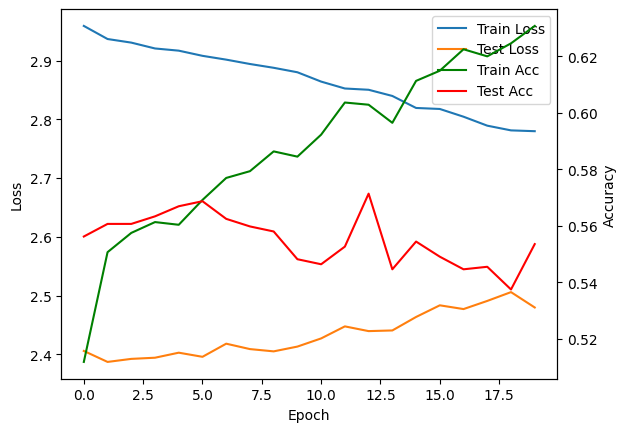

In [2758]:
results = train(
            model=model,
            train_dataloader=train_loader,
            test_dataloader=valid_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epochs=5,
            device=device)

plot_results(results)

In [2759]:
test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}')
print(f'Test acc:  {test_acc:.4f}')

Test loss: 3.5649
Test acc:  0.5379


In [359]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)

e = shap.DeepExplainer(model, X)
shap_values = e.shap_values(X)

In [651]:
np.abs(shap_values).max(axis=1)


array([0.00092442, 0.00089863, 0.0008516 , 0.0008234 , 0.00073681,
       0.00069524, 0.00067206, 0.0005455 , 0.00050007, 0.00040861,
       0.00039408, 0.00037737, 0.00036652, 0.00035392, 0.00025704,
       0.00025255, 0.0003168 , 0.00023832, 0.00044233, 0.00047225,
       0.00046906, 0.00067196, 0.00078152, 0.00082955, 0.00071082,
       0.00064273, 0.00066478, 0.00071363, 0.0007198 , 0.00075376,
       0.00083715, 0.00085948])